# Global Forecasting Models: time series with different lengths and different exogenous variables

When faced with a multi-series forecasting problem, it is common for the series to have varying lengths due to differences in the starting times of data recording. To address this scenario, the [ForecasterAutoregMultiSeries](https://skforecast.org/0.11.0/user_guides/independent-multi-time-series-forecasting) calss allows to model simultaneously time series of different lengths and with different exogenous variables.

+ When the modeled series have different lengths, they must be stored in a Python dictionary. The keys of the dictionary are the names of the series and the values are the series themselves. All series must be of type `pandas.Series`, have a `datetime` index and have the same frequency.

    | Series values                            | Allowed |
    |:-----------------------------------------|:-------:|
    | `[NaN, NaN, NaN, NaN, 4, 5, 6, 7, 8, 9]` |✔️       |
    | `[0, 1, 2, 3, 4, 5, 6, 7, 8, NaN]`       |✔️       |
    | `[0, 1, 2, 3, 4, NaN, 6, 7, 8, 9]`       |✔️       |
    | `[NaN, NaN, 2, 3, 4, NaN, 6, 7, 8, 9]`   |✔️       |

<br>

+ When different exogenous variables are used for each series or when the exogenous variables are the same but have different values for each series, they must be stored in a dictionary. The keys of the dictionary are the names of the series and the values are the exogenous variables themselves. All exogenous variables must be of type `pandas.DataFrame` or `pandas.Series`.

## Libraries

In [29]:
# Libraries
# ==============================================================================
import pandas as pd
import warnings
import matplotlib.pyplot as plt
from skforecast.plot import set_dark_theme
from lightgbm import LGBMRegressor
from skforecast.preprocessing import series_long_to_dict
from skforecast.preprocessing import exog_long_to_dict
from skforecast.ForecasterAutoregMultiSeries import ForecasterAutoregMultiSeries
from skforecast.model_selection_multiseries import backtesting_forecaster_multiseries
from skforecast.model_selection_multiseries import bayesian_search_forecaster_multiseries

## Data

In [30]:
# Load time series of multiple lengths and exogenous variables
# ==============================================================================
series = pd.read_csv(
    'https://raw.githubusercontent.com/JoaquinAmatRodrigo/skforecast-datasets/main/data/demo_multi_series.csv'
)
exog = pd.read_csv(
    'https://raw.githubusercontent.com/JoaquinAmatRodrigo/skforecast-datasets/main/data/demo_multi_series_exog.csv'
)
series['timestamp'] = pd.to_datetime(series['timestamp'])
exog['timestamp'] = pd.to_datetime(exog['timestamp'])
display(series.head())
display(exog.head())

,series_id,timestamp,value
0,id_1000,2016-01-01,1012.500694
1,id_1000,2016-01-02,1158.500099
2,id_1000,2016-01-03,983.000099
3,id_1000,2016-01-04,1675.750496
4,id_1000,2016-01-05,1586.250694


,series_id,timestamp,sin_day_of_week,cos_day_of_week,air_temperature,wind_speed
0,id_1000,2016-01-01,-0.433884,-0.900969,6.416639,4.040115
1,id_1000,2016-01-02,-0.974928,-0.222521,6.366474,4.530395
2,id_1000,2016-01-03,-0.781831,0.623490,6.555272,3.273064
3,id_1000,2016-01-04,0.000000,1.000000,6.704778,4.865404
4,id_1000,2016-01-05,0.781831,0.623490,2.392998,5.228913


In [31]:
# Transform series and exog to dictionaries
# ==============================================================================
series_dict = series_long_to_dict(
    data = series,
    series_id = 'series_id',
    index = 'timestamp',
    values = 'value',
    freq = 'D'
)

exog_dict = exog_long_to_dict(
    data = exog,
    series_id = 'series_id',
    index = 'timestamp',
    freq = 'D'
)

exog_dict['id_1000'] = exog_dict['id_1000'].drop(columns=['air_temperature', 'wind_speed'])
exog_dict['id_1003'] = exog_dict['id_1003'].drop(columns=['cos_day_of_week'])

In [32]:
# Partition data in train and test
# ==============================================================================
end_train = '2016-07-31 23:59:00'
series_dict_train = {k: v.loc[: end_train,] for k, v in series_dict.items()}
exog_dict_train   = {k: v.loc[: end_train,] for k, v in exog_dict.items()}
series_dict_test  = {k: v.loc[end_train:,] for k, v in series_dict.items()}
exog_dict_test    = {k: v.loc[end_train:,] for k, v in exog_dict.items()}

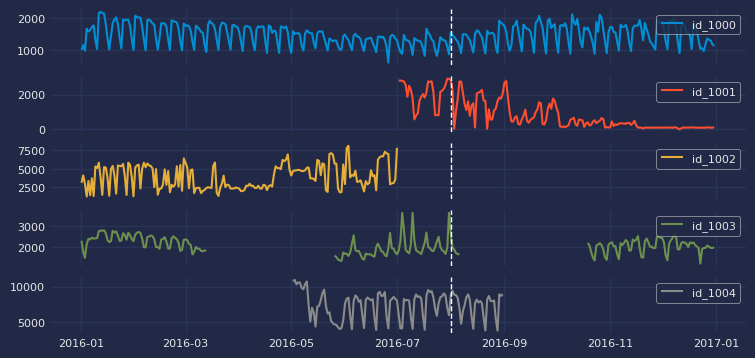

In [33]:
# Plot series
# ==============================================================================
set_dark_theme()
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
fig, axs = plt.subplots(5, 1, figsize=(8, 4), sharex=True)
for i, s in enumerate(series_dict.values()):
    axs[i].plot(s, label=s.name, color=colors[i])
    axs[i].legend(loc='upper right', fontsize=8)
    axs[i].tick_params(axis='both', labelsize=8)
    # axs[i].axvline(end_train)
    axs[i].axvline(pd.to_datetime(end_train) , color='white', linestyle='--', linewidth=1)

In [34]:
# Description of each partition
# ==============================================================================
for k in series_dict.keys():
    print(f"{k}:")
    try:
        print(
            f"\tTrain: len={len(series_dict_train[k])}, {series_dict_train[k].index[0]}"
            f" --- {series_dict_train[k].index[-1]}"
        )
    except:
        print(f"\tTrain: len=0")
    try:
        print(
            f"\tTest : len={len(series_dict_test[k])}, {series_dict_test[k].index[0]}"
            f" --- {series_dict_test[k].index[-1]}"
        )
    except:
        print(f"\tTest : len=0")

id_1000:
	Train: len=213, 2016-01-01 00:00:00 --- 2016-07-31 00:00:00
	Test : len=153, 2016-08-01 00:00:00 --- 2016-12-31 00:00:00
id_1001:
	Train: len=30, 2016-07-02 00:00:00 --- 2016-07-31 00:00:00
	Test : len=153, 2016-08-01 00:00:00 --- 2016-12-31 00:00:00
id_1002:
	Train: len=183, 2016-01-01 00:00:00 --- 2016-07-01 00:00:00
	Test : len=0
id_1003:
	Train: len=213, 2016-01-01 00:00:00 --- 2016-07-31 00:00:00
	Test : len=153, 2016-08-01 00:00:00 --- 2016-12-31 00:00:00
id_1004:
	Train: len=91, 2016-05-02 00:00:00 --- 2016-07-31 00:00:00
	Test : len=31, 2016-08-01 00:00:00 --- 2016-08-31 00:00:00


In [35]:
# Exogenous variables for each series
# ==============================================================================
for k in series_dict.keys():
    print(f"{k}:")
    try:
        print(f"\t{exog_dict[k].columns.to_list()}")
    except:
        print(f"\tNo exogenous variables")

id_1000:
	['sin_day_of_week', 'cos_day_of_week']
id_1001:
	['sin_day_of_week', 'cos_day_of_week', 'air_temperature', 'wind_speed']
id_1002:
	['sin_day_of_week', 'cos_day_of_week', 'air_temperature', 'wind_speed']
id_1003:
	['sin_day_of_week', 'air_temperature', 'wind_speed']
id_1004:
	['sin_day_of_week', 'cos_day_of_week', 'air_temperature', 'wind_speed']


## Train and predict ForecasterAutoregMultiSeries

In [36]:
# Fit forecaster
# ==============================================================================
regressor = LGBMRegressor(random_state=123, verbose=-1, max_depth=5)
forecaster = ForecasterAutoregMultiSeries(
    regressor=regressor, lags=14, encoding="ordinal", dropna_from_series=False
)
forecaster.fit(series=series_dict_train, exog=exog_dict_train, suppress_warnings=True)
forecaster

ForecasterAutoregMultiSeries 
Regressor: LGBMRegressor(max_depth=5, random_state=123, verbose=-1) 
Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14] 
Transformer for series: StandardScaler() 
Transformer for exog: None 
Series encoding: ordinal 
Window size: 14 
Series levels (names): ['id_1000', 'id_1001', 'id_1002', 'id_1003', 'id_1004'] 
Series weights: None 
Weight function included: False 
Differentiation order: None 
Exogenous included: True 
Type of exogenous variable: <class 'dict'> 
Exogenous variables names: ['sin_day_of_week', 'cos_day_of_week', 'air_temperature', 'wind_speed'] 
Training range: 'id_1000': ['2016-01-01', '2016-07-31'], 'id_1001': ['2016-07-02', '2016-07-31'], 'id_1002': ['2016-01-01', '2016-07-01'], ... 
Training index type: DatetimeIndex 
Training index frequency: D 
Regressor parameters: boosting_type: gbdt, class_weight: None, colsample_bytree: 1.0, importance_type: split, learning_rate: 0.1, ... 
fit_kwargs: {} 
Creation date: 2024-04-15 16:10:24 
Last fi

In [37]:
predictions = forecaster.predict(steps=5, exog=exog_dict_test, suppress_warnings=True)
predictions

,id_1000,id_1001,id_1003,id_1004
2016-08-01,1293.204467,2524.395199,2709.278962,7832.637393
2016-08-02,1406.194447,2352.220339,2374.673568,8211.355533
2016-08-03,1373.037098,2448.617991,2151.117183,8691.257605
2016-08-04,1322.956825,2350.717306,2038.462016,8580.422024
2016-08-05,1236.472191,2175.728026,1927.793418,9066.134443


## Backtesting

When series have different lengths, the backtesting process only returns predictions for the datetimes that are present in the series.

In [38]:
# Backtesting
# ==============================================================================
forecaster = ForecasterAutoregMultiSeries(
    regressor=regressor, lags=14, encoding="ordinal", dropna_from_series=False
)

metrics_levels, backtest_predictions = backtesting_forecaster_multiseries(
    forecaster=forecaster,
    series=series_dict,
    exog=exog_dict,
    steps=24,
    metric="mean_absolute_error",
    initial_train_size=len(series_dict_train["id_1000"]),
    fixed_train_size=True,
    gap=0,
    allow_incomplete_fold=True,
    refit=False,
    n_jobs="auto",
    verbose=True,
    show_progress=True,
    suppress_warnings=True,
)

display(metrics_levels)
display(backtest_predictions)

Information of backtesting process
----------------------------------
Number of observations used for initial training: 213
Number of observations used for backtesting: 153
    Number of folds: 7
    Number of steps per fold: 24
    Number of steps to exclude from the end of each train set before test (gap): 0
    Last fold only includes 9 observations.

Fold: 0
    Training:   2016-01-01 00:00:00 -- 2016-07-31 00:00:00  (n=213)
    Validation: 2016-08-01 00:00:00 -- 2016-08-24 00:00:00  (n=24)
Fold: 1
    Training:   2016-01-01 00:00:00 -- 2016-07-31 00:00:00  (n=213)
    Validation: 2016-08-25 00:00:00 -- 2016-09-17 00:00:00  (n=24)
Fold: 2
    Training:   2016-01-01 00:00:00 -- 2016-07-31 00:00:00  (n=213)
    Validation: 2016-09-18 00:00:00 -- 2016-10-11 00:00:00  (n=24)
Fold: 3
    Training:   2016-01-01 00:00:00 -- 2016-07-31 00:00:00  (n=213)
    Validation: 2016-10-12 00:00:00 -- 2016-11-04 00:00:00  (n=24)
Fold: 4
    Training:   2016-01-01 00:00:00 -- 2016-07-31 00:00:00  (n=

  0%|          | 0/7 [00:00<?, ?it/s]

,levels,mean_absolute_error
0,id_1000,170.480334
1,id_1001,898.507443
2,id_1002,NaN
3,id_1003,312.142117
4,id_1004,1016.918515


,id_1000,id_1001,id_1003,id_1004
2016-08-01,1293.204467,2524.395199,2709.278962,7832.637393
2016-08-02,1406.194447,2352.220339,2374.673568,8211.355533
2016-08-03,1373.037098,2448.617991,2151.117183,8691.257605
2016-08-04,1322.956825,2350.717306,2038.462016,8580.422024
2016-08-05,1236.472191,2175.728026,1927.793418,9066.134443
...,...,...,...,...
2016-12-27,1707.247192,1090.228639,1917.176341,NaN
2016-12-28,1657.671846,1095.269468,1764.954581,NaN
2016-12-29,1435.185437,1202.631403,1808.017876,NaN
2016-12-30,1397.272408,1323.913812,1943.009954,NaN


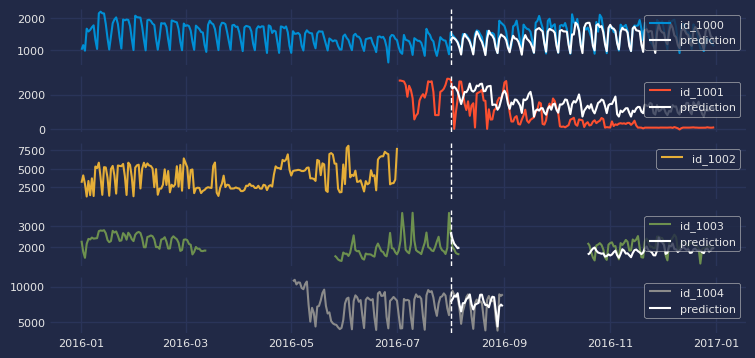

In [39]:
# Plot backtesting predictions
# ==============================================================================
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
fig, axs = plt.subplots(5, 1, figsize=(8, 4), sharex=True)
for i, s in enumerate(series_dict.keys()):
    axs[i].plot(series_dict[s], label=series_dict[s].name, color=colors[i])
    axs[i].axvline(pd.to_datetime(end_train) , color='white', linestyle='--', linewidth=1)
    try:
        axs[i].plot(backtest_predictions[s], label='prediction', color="white")
    except:
        pass
    axs[i].legend(loc='upper right', fontsize=8)
    axs[i].tick_params(axis='both', labelsize=8)

## Bayesian search

In [40]:
# Bayesian search
# ==============================================================================
forecaster = ForecasterAutoregMultiSeries(
    regressor=regressor,
    lags=14,
    encoding="ordinal",
    dropna_from_series=False
)

lags_grid = [
    [5],
    [1, 7, 14]
]

def search_space(trial):
    search_space  = {
        "n_estimators": trial.suggest_int("n_estimators", 2, 20),
        "max_depth": trial.suggest_int('max_depth', 2, 5),
        'lags' : trial.suggest_categorical('lags', lags_grid)
    }

    return search_space

with warnings.catch_warnings():
    warnings.filterwarnings('ignore')

    results_search, best_trial = bayesian_search_forecaster_multiseries(
        forecaster         = forecaster,
        series             = series_dict,
        exog               = exog_dict,
        search_space       = search_space,
        metric             = 'mean_absolute_error',
        initial_train_size = len(series_dict_train['id_1000']),
        steps              = 24,
        refit              = False,
        n_trials           = 10,
        return_best        = False,
        show_progress      = False,
        verbose            = False,
        suppress_warnings  = True
    )

results_search

/home/ubuntu/anaconda3/envs/skforecast_11_py11/lib/python3.11/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [5] which is of type list.
  warnings.warn(message)
/home/ubuntu/anaconda3/envs/skforecast_11_py11/lib/python3.11/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [1, 7, 14] which is of type list.
  warnings.warn(message)


,levels,lags,params,mean_absolute_error,n_estimators,max_depth
0,"[id_1000, id_1001, id_1002, id_1003, id_1004]","[1, 7, 14]","{'n_estimators': 15, 'max_depth': 3}",569.124207,15,3
2,"[id_1000, id_1001, id_1002, id_1003, id_1004]","[1, 7, 14]","{'n_estimators': 11, 'max_depth': 3}",609.096710,11,3
3,"[id_1000, id_1001, id_1002, id_1003, id_1004]","[1, 7, 14]","{'n_estimators': 10, 'max_depth': 2}",638.722724,10,2
7,"[id_1000, id_1001, id_1002, id_1003, id_1004]","[1, 7, 14]","{'n_estimators': 7, 'max_depth': 4}",646.199713,7,4
5,"[id_1000, id_1001, id_1002, id_1003, id_1004]",[5],"{'n_estimators': 14, 'max_depth': 5}",690.642743,14,5
9,"[id_1000, id_1001, id_1002, id_1003, id_1004]",[5],"{'n_estimators': 10, 'max_depth': 5}",704.493013,10,5
1,"[id_1000, id_1001, id_1002, id_1003, id_1004]",[5],"{'n_estimators': 15, 'max_depth': 3}",709.976696,15,3
6,"[id_1000, id_1001, id_1002, id_1003, id_1004]",[5],"{'n_estimators': 15, 'max_depth': 3}",709.976696,15,3
4,"[id_1000, id_1001, id_1002, id_1003, id_1004]","[1, 7, 14]","{'n_estimators': 5, 'max_depth': 2}",713.057771,5,2
8,"[id_1000, id_1001, id_1002, id_1003, id_1004]",[5],"{'n_estimators': 10, 'max_depth': 3}",724.367248,10,3
